In [56]:
import numpy as np
import pandas as pd
import risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n_scenarios = 5000
rates , zc_prices = erk.cir(10,n_scenarios, b=0.03, r_0 = 0.03, sigma = 0.02)
price_eq = erk.gbm(n_years = 10, n_scenarios = n_scenarios, mu = 0.07, sigma = 0.15)

In [3]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1 = 0.7)

In [4]:
pd.concat([
    erk.terminal_stats(rets_zc, name = 'Zero Coupon Bond', floor = 0.75),
    erk.terminal_stats(rets_eq, name = 'Eq', floor = 0.75),
    erk.terminal_stats(rets_7030b, name = '70/30b', floor = 0.75)
], axis = 1).round(2)

,Zero Coupon Bond,Eq,70/30b
mean,1.34,1.97,1.76
std,0.00,1.01,0.61
p_breach,NaN,0.04,0.01
e_short,NaN,0.13,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [5]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m = 3):
    """
    Allocate between p* seeking protifolio and global hedging portifolio (GHP) with the goal to provide exposure to the upside of the PSP without violating the floor.
    Uses CPPI-Stle dynamic risk budeting algorithm by investing a multiple of the cushion in PSP
    Returns a DataFrame with the same sahpe as the psps/ghp representating the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError('PSP and ZC Prices must have the same shape')
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index = psp_r.index, columns = psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ##PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor)/account_value
        psp_w = (m*cushion).clip(0,1)
        ghp_w = 1 -psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        ##recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
        
        return w_history
        

In [19]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1 = 0.7)
rets_75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor = 0.75, zc_prices = zc_prices[1:])
rets_75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor = 0.75, zc_prices = zc_prices[1:], m =1)
rets_75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor = 0.75, zc_prices = zc_prices[1:], m =5)

In [21]:
pd.concat([
    erk.terminal_stats(rets_zc, name = 'Zero Coupon Bond', floor = 0.75),
    erk.terminal_stats(rets_eq, name = 'Eq', floor = 0.75),
    erk.terminal_stats(rets_7030b, name = '70/30b', floor = 0.75),
    erk.terminal_stats(rets_75, name = 'Floor75', floor = 0.75),
    erk.terminal_stats(rets_75m1, name = 'Floor75m1', floor = 0.75),
    erk.terminal_stats(rets_75m5, name = 'Floor75m5', floor = 0.75)
], axis = 1).round(2)

,Zero Coupon Bond,Eq,70/30b,Floor75,Floor75m1,Floor75m5
mean,1.34,1.97,1.76,1.95,1.62,1.96
std,0.00,1.01,0.61,1.01,0.44,1.01
p_breach,NaN,0.04,0.01,NaN,NaN,NaN
e_short,NaN,0.13,0.08,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


### Risk Budgeting with Drawdown Constraints


In [46]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index = rets_eq.index, columns = rets_eq.columns)

In [51]:
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawndown_allocator, maxdd= 0.25)

In [63]:
pd.concat([
    erk.terminal_stats(rets_zc, name = 'Zero Coupon Bond', floor = 0.75),
    erk.terminal_stats(rets_eq, name = 'Eq', floor = 0.75),
    erk.terminal_stats(rets_7030b, name = '70/30b', floor = 0.75),
    erk.terminal_stats(rets_75, name = 'Floor75', floor = 0.75),
    erk.terminal_stats(rets_75m1, name = 'Floor75m1', floor = 0.75),
    erk.terminal_stats(rets_75m5, name = 'Floor75m5', floor = 0.75),
    erk.terminal_stats(rets_maxdd25, name = 'max_dd', floor = 0.75)
], axis = 1).round(2)

,Zero Coupon Bond,Eq,70/30b,Floor75,Floor75m1,Floor75m5,max_dd
mean,1.34,1.97,1.76,1.95,1.62,1.96,1.63
std,0.00,1.01,0.61,1.01,0.44,1.01,0.55
p_breach,NaN,0.04,0.01,NaN,NaN,NaN,NaN
e_short,NaN,0.13,0.08,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
erk.summary_stats(rets_maxdd25)['Max Drawdown'].min()

-0.23830084090742853

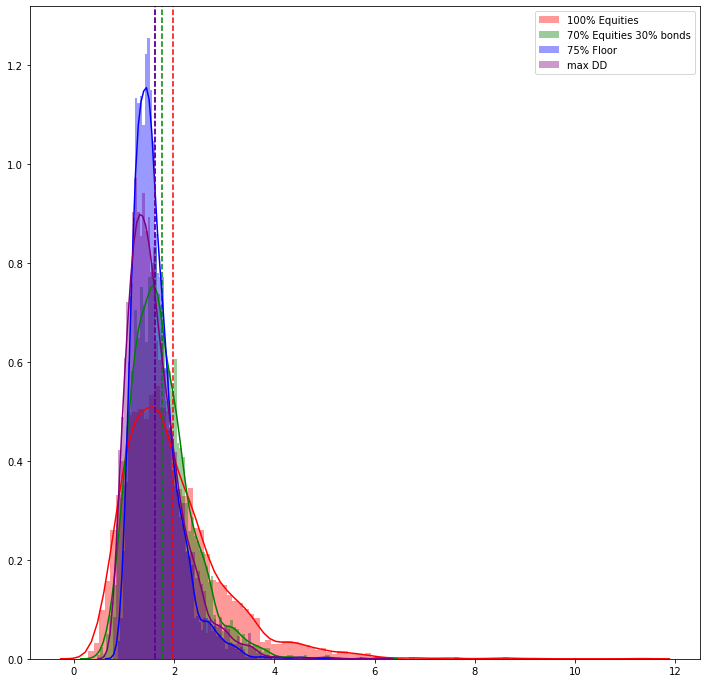

In [85]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_75m1)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

#plot
plt.figure(figsize = (12,12))
sns.distplot(tv_eq, color='red', label = '100% Equities', bins = 100)
plt.axvline(tv_eq.mean(), ls='--', color = 'red')

sns.distplot(tv_7030b, color='green', label = '70% Equities 30% bonds', bins = 100)
plt.axvline(tv_7030b.mean(), ls='--', color = 'green')

sns.distplot(tv_floor75, color='blue', label = '75% Floor', bins = 100)
plt.axvline(tv_floor75.mean(), ls='--', color = 'blue')

sns.distplot(tv_maxdd25, color='purple', label = 'max DD', bins = 100)
plt.axvline(tv_maxdd25.mean(), ls='--', color = 'purple')


plt.legend()



# Drawndown Constraint with Historical Data

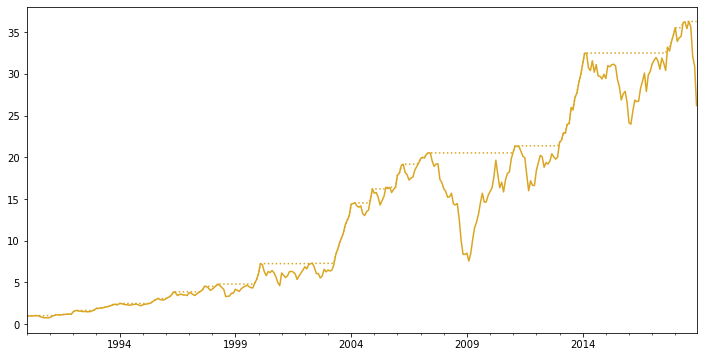

In [97]:
rets_tmi = erk.get_ffme_returns().SmallCap['1990':]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi['Wealth'].plot(figsize = (12,6), ls= '-', color ='goldenrod')
dd_tmi['Peaks'].plot(ax = ax, ls=':', color = 'goldenrod')

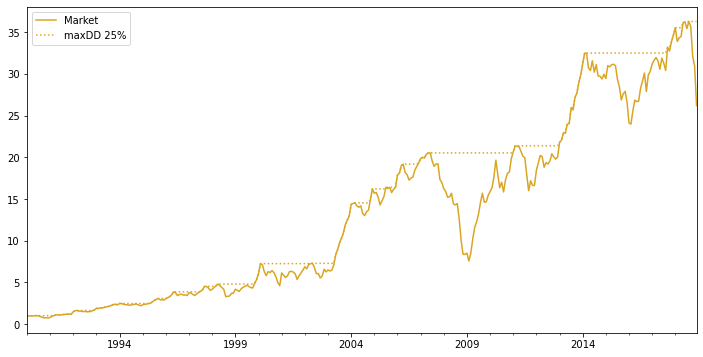

In [100]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index =rets_tmi.index, columns = [0])
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawndown_allocator, maxdd= 0.25, m = 5)
dd_25 = erk.drawdown(rets_maxdd25[0])



ax = dd_tmi['Wealth'].plot(figsize = (12,6), ls= '-', color ='goldenrod', label = 'Market', legend = True)
dd_tmi['Peaks'].plot(ax = ax, ls=':', color = 'goldenrod')
dd_25['Wealth'].plot(ax = ax, label ='maxDD 25%', color = 'cornflowerblue', legend = True)
dd_25['Peaks'].plot(ax=ax, color='cornflowerblue', ls=':')